In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
           'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Super useful! The DataLoader, in particular, is quite exciting. I'll have to check out the details later.

 deer truck  frog truck


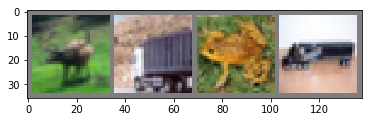

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
(images, labels) = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

I like `make_grid()`; very useful. Also, I just learned that `%matplotlib inline` makes graphs 'n such show inline in IPython Notebooks, which is neat. 

In [14]:
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as functional

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(functional.relu(self.conv1(x)))
        x = self.pool(functional.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
net.cuda()

Net (
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)

In [15]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

How easy it was to add momentum! I am astounded. I am surprised. I am pleased!

In [16]:
for epoch in range(2):
    running_loss = 0.0
    for (i, data) in enumerate(trainloader, 0):
        (inputs, labels) = data
        inputs = autograd.Variable(inputs).cuda()
        labels = autograd.Variable(labels).cuda()
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.182
[1,  4000] loss: 1.872
[1,  6000] loss: 1.687
[1,  8000] loss: 1.583
[1, 10000] loss: 1.512
[1, 12000] loss: 1.499
[2,  2000] loss: 1.432
[2,  4000] loss: 1.380
[2,  6000] loss: 1.350
[2,  8000] loss: 1.342
[2, 10000] loss: 1.296
[2, 12000] loss: 1.281
Finished Training


GroundTruth:    cat  ship  ship plane


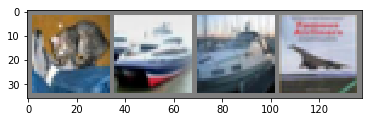

In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [20]:
outputs = net(autograd.Variable(images).cuda()).cpu()
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car  ship  ship


Something I learned here: I need to be aware of when things are expected to be on CPU vs GPU. Since I called `net.cuda()` earlier, the variable passed to `net()` must be on the GPU. If I hadn't called `net.cuda()`, then the above code would raise an exception. 

In [22]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(autograd.Variable(images).cuda()).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' %
      (100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(autograd.Variable(images).cuda()).cpu()
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 50 %
Accuracy of  bird : 37 %
Accuracy of   cat : 35 %
Accuracy of  deer : 57 %
Accuracy of   dog : 47 %
Accuracy of  frog : 57 %
Accuracy of horse : 68 %
Accuracy of  ship : 81 %
Accuracy of truck : 62 %
